In [1]:
import numpy as np
from numpy import genfromtxt
from itertools import combinations
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
data = genfromtxt('small_file_correct_coord.txt', delimiter=',')
#data = genfromtxt('small_file.txt', delimiter=',')
data[:,4] =(data[:,4]-np.min(data[:,4]))/(np.max(data[:,4])-np.min(data[:,4]))
print(data)

[[ 0.          1.128016    0.913283   -2.69977     0.27121927]
 [ 1.          0.952915    0.519144    0.878809    0.95261156]
 [ 1.          0.434082    0.56767    -2.311936    0.93668561]
 [ 2.          2.209619    1.105468    2.333682    0.52416023]
 [ 3.          1.71197     1.189179    1.119164    0.78435412]
 [ 3.          0.461599    0.777167   -0.144536    0.75403444]
 [ 4.          2.029792    1.287946    1.30295     0.        ]
 [ 5.          0.756178    1.33176    -2.309371    0.68407621]
 [ 6.          2.1872      0.476108    2.85122     0.8842718 ]
 [ 7.          1.921325    1.287711   -2.407052    1.        ]
 [ 7.          0.24677     0.972258    1.512456    0.95922116]
 [ 8.          2.12424     1.190137    0.532672    0.63181968]
 [ 9.          2.165567    0.780356    1.333373    0.52338727]
 [10.          1.927867    0.979187   -1.390222    0.83159162]
 [10.          0.155214    1.058012   -2.217043    0.81032574]
 [11.          2.17151     0.581699   -0.050691    0.75

### reshape data

In [3]:
#print(np.min(data,axis=0)[0])
ll = []
true_vals = []
for i in range(int(np.min(data,axis=0)[0]),int(np.max(data,axis=0)[0]),3):
    mask = ((data[:,0] == i) | (data[:,0] == i+1) | (data[:,0] == i+2))
    evt = data[mask]
    #print(evt)
    #print(evt.shape[0])
    pair_indices = list(combinations(range(evt.shape[0]), 2))
    #print(pair_indices)
    for i, (idx1, idx2) in enumerate(pair_indices):
        l = []
        l.append(np.concatenate((evt[idx1,1:],evt[idx2,1:])))
        ll.append(l)
        if (evt[idx1,0] == evt[idx2,0]):
            true_vals.append(1)
        else:
            true_vals.append(0)
print(ll)
input_data = torch.FloatTensor(ll)
input_data = torch.squeeze(input_data)
input_data.shape
truth_class = torch.FloatTensor(true_vals)
print(truth_class.shape)

[[array([ 1.128016  ,  0.913283  , -2.69977   ,  0.27121927,  0.952915  ,
        0.519144  ,  0.878809  ,  0.95261156])], [array([ 1.128016  ,  0.913283  , -2.69977   ,  0.27121927,  0.434082  ,
        0.56767   , -2.311936  ,  0.93668561])], [array([ 1.128016  ,  0.913283  , -2.69977   ,  0.27121927,  2.209619  ,
        1.105468  ,  2.333682  ,  0.52416023])], [array([ 0.952915  ,  0.519144  ,  0.878809  ,  0.95261156,  0.434082  ,
        0.56767   , -2.311936  ,  0.93668561])], [array([0.952915  , 0.519144  , 0.878809  , 0.95261156, 2.209619  ,
       1.105468  , 2.333682  , 0.52416023])], [array([ 0.434082  ,  0.56767   , -2.311936  ,  0.93668561,  2.209619  ,
        1.105468  ,  2.333682  ,  0.52416023])], [array([ 1.71197   ,  1.189179  ,  1.119164  ,  0.78435412,  0.461599  ,
        0.777167  , -0.144536  ,  0.75403444])], [array([1.71197   , 1.189179  , 1.119164  , 0.78435412, 2.029792  ,
       1.287946  , 1.30295   , 0.        ])], [array([ 1.71197   ,  1.189179  ,  1.11

/home/tobiasjenegger/jupy/jup_notebook/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


### simple model

In [4]:
class feed_forward_model(nn.Module):
        def __init__(self):
                super().__init__()
                self.linear = torch.nn.Linear(8,1000)
                #self.another_linear = torch.nn.Linear(100,100)
                self.activation = torch.nn.ReLU()
                self.linear_back = torch.nn.Linear(1000,1)

        def forward(self, x):
                output_tensor = self.linear(x)
                #output_tensor = self.another_linear(output_tensor)
                #output_tensor = self.activation(output_tensor)
                output_tensor = self.linear_back(output_tensor)
                output_tensor = torch.sigmoid(output_tensor)
                output_tensor = torch.squeeze(output_tensor)
                return output_tensor


## final training

In [5]:
print(input_data.shape)
n_epochs = 1000
model = feed_forward_model()
loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.SGD(model.parameters(), lr=9e-4)
model.train()
loss_val = []
for epoch in range(n_epochs):
    y_pred = model(input_data)
    y_true = truth_class
    loss = loss_fn(y_pred,y_true)
    loss_val.append(loss.detach().item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')
    torch.save(model,"ff_scripted.pt")

torch.Size([57, 8])
Finished epoch 0, latest loss 0.5777357816696167
Finished epoch 1, latest loss 0.553840696811676
Finished epoch 2, latest loss 0.5332217216491699
Finished epoch 3, latest loss 0.5153736472129822
Finished epoch 4, latest loss 0.49987104535102844
Finished epoch 5, latest loss 0.4863564968109131
Finished epoch 6, latest loss 0.4745306670665741
Finished epoch 7, latest loss 0.46414273977279663
Finished epoch 8, latest loss 0.45498257875442505
Finished epoch 9, latest loss 0.4468739926815033
Finished epoch 10, latest loss 0.43966856598854065
Finished epoch 11, latest loss 0.43324142694473267
Finished epoch 12, latest loss 0.4274870455265045
Finished epoch 13, latest loss 0.4223158061504364
Finished epoch 14, latest loss 0.41765183210372925
Finished epoch 15, latest loss 0.41343018412590027
Finished epoch 16, latest loss 0.4095955193042755
Finished epoch 17, latest loss 0.40610021352767944
Finished epoch 18, latest loss 0.4029034376144409
Finished epoch 19, latest loss 0.

Finished epoch 170, latest loss 0.30478957295417786
Finished epoch 171, latest loss 0.30445849895477295
Finished epoch 172, latest loss 0.30412882566452026
Finished epoch 173, latest loss 0.303800493478775
Finished epoch 174, latest loss 0.303473562002182
Finished epoch 175, latest loss 0.30314791202545166
Finished epoch 176, latest loss 0.30282366275787354
Finished epoch 177, latest loss 0.3025006651878357
Finished epoch 178, latest loss 0.3021790683269501
Finished epoch 179, latest loss 0.30185872316360474
Finished epoch 180, latest loss 0.30153974890708923
Finished epoch 181, latest loss 0.301222026348114
Finished epoch 182, latest loss 0.30090558528900146
Finished epoch 183, latest loss 0.300590455532074
Finished epoch 184, latest loss 0.30027657747268677
Finished epoch 185, latest loss 0.2999640107154846
Finished epoch 186, latest loss 0.29965269565582275
Finished epoch 187, latest loss 0.2993425726890564
Finished epoch 188, latest loss 0.2990337610244751
Finished epoch 189, lates

Finished epoch 330, latest loss 0.26517507433891296
Finished epoch 331, latest loss 0.26499196887016296
Finished epoch 332, latest loss 0.2648095190525055
Finished epoch 333, latest loss 0.2646276652812958
Finished epoch 334, latest loss 0.2644464075565338
Finished epoch 335, latest loss 0.2642657458782196
Finished epoch 336, latest loss 0.26408568024635315
Finished epoch 337, latest loss 0.26390618085861206
Finished epoch 338, latest loss 0.2637273073196411
Finished epoch 339, latest loss 0.26354900002479553
Finished epoch 340, latest loss 0.2633712887763977
Finished epoch 341, latest loss 0.26319414377212524
Finished epoch 342, latest loss 0.26301756501197815
Finished epoch 343, latest loss 0.2628416121006012
Finished epoch 344, latest loss 0.2626661956310272
Finished epoch 345, latest loss 0.2624913156032562
Finished epoch 346, latest loss 0.26231706142425537
Finished epoch 347, latest loss 0.2621433436870575
Finished epoch 348, latest loss 0.261970192193985
Finished epoch 349, late

Finished epoch 493, latest loss 0.24167212843894958
Finished epoch 494, latest loss 0.24155884981155396
Finished epoch 495, latest loss 0.2414458692073822
Finished epoch 496, latest loss 0.24133320152759552
Finished epoch 497, latest loss 0.24122078716754913
Finished epoch 498, latest loss 0.24110867083072662
Finished epoch 499, latest loss 0.240996852517128
Finished epoch 500, latest loss 0.24088533222675323
Finished epoch 501, latest loss 0.24077410995960236
Finished epoch 502, latest loss 0.24066312611103058
Finished epoch 503, latest loss 0.24055245518684387
Finished epoch 504, latest loss 0.24044205248355865
Finished epoch 505, latest loss 0.24033193290233612
Finished epoch 506, latest loss 0.24022209644317627
Finished epoch 507, latest loss 0.2401125282049179
Finished epoch 508, latest loss 0.24000327289104462
Finished epoch 509, latest loss 0.23989427089691162
Finished epoch 510, latest loss 0.2397855520248413
Finished epoch 511, latest loss 0.23967710137367249
Finished epoch 51

Finished epoch 652, latest loss 0.22668415307998657
Finished epoch 653, latest loss 0.2266056388616562
Finished epoch 654, latest loss 0.22652725875377655
Finished epoch 655, latest loss 0.22644902765750885
Finished epoch 656, latest loss 0.22637097537517548
Finished epoch 657, latest loss 0.22629310190677643
Finished epoch 658, latest loss 0.22621533274650574
Finished epoch 659, latest loss 0.22613774240016937
Finished epoch 660, latest loss 0.22606031596660614
Finished epoch 661, latest loss 0.22598303854465485
Finished epoch 662, latest loss 0.22590592503547668
Finished epoch 663, latest loss 0.22582894563674927
Finished epoch 664, latest loss 0.22575213015079498
Finished epoch 665, latest loss 0.22567547857761383
Finished epoch 666, latest loss 0.22559897601604462
Finished epoch 667, latest loss 0.22552260756492615
Finished epoch 668, latest loss 0.225446417927742
Finished epoch 669, latest loss 0.2253703773021698
Finished epoch 670, latest loss 0.22529444098472595
Finished epoch 6

Finished epoch 822, latest loss 0.21525105834007263
Finished epoch 823, latest loss 0.21519333124160767
Finished epoch 824, latest loss 0.21513567864894867
Finished epoch 825, latest loss 0.21507816016674042
Finished epoch 826, latest loss 0.21502068638801575
Finished epoch 827, latest loss 0.21496331691741943
Finished epoch 828, latest loss 0.2149060219526291
Finished epoch 829, latest loss 0.2148488461971283
Finished epoch 830, latest loss 0.21479174494743347
Finished epoch 831, latest loss 0.2147347629070282
Finished epoch 832, latest loss 0.2146778702735901
Finished epoch 833, latest loss 0.21462102234363556
Finished epoch 834, latest loss 0.21456433832645416
Finished epoch 835, latest loss 0.21450765430927277
Finished epoch 836, latest loss 0.21445110440254211
Finished epoch 837, latest loss 0.214394673705101
Finished epoch 838, latest loss 0.2143382877111435
Finished epoch 839, latest loss 0.21428202092647552
Finished epoch 840, latest loss 0.21422578394412994
Finished epoch 841,

Finished epoch 987, latest loss 0.20680689811706543
Finished epoch 988, latest loss 0.2067614197731018
Finished epoch 989, latest loss 0.20671604573726654
Finished epoch 990, latest loss 0.20667073130607605
Finished epoch 991, latest loss 0.20662544667720795
Finished epoch 992, latest loss 0.206580251455307
Finished epoch 993, latest loss 0.20653507113456726
Finished epoch 994, latest loss 0.20648996531963348
Finished epoch 995, latest loss 0.20644496381282806
Finished epoch 996, latest loss 0.20639993250370026
Finished epoch 997, latest loss 0.2063550055027008
Finished epoch 998, latest loss 0.20631015300750732
Finished epoch 999, latest loss 0.20626534521579742


Text(0, 0.5, 'loss value')

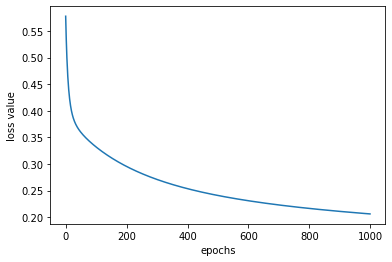

In [6]:
plt.plot(loss_val)
plt.xlabel("epochs")
plt.ylabel("loss value")

### look at pred. value distributions

In [7]:
#ff_model = feed_forward_model()
with torch.no_grad():
    model = torch.load("ff_scripted.pt")
    model.eval()
    
eval_pred = model(input_data).detach().numpy()   
eval_true = truth_class.detach().numpy()




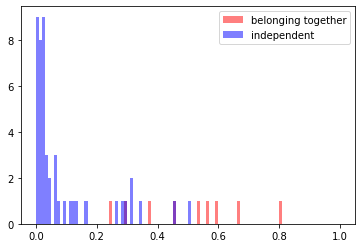

In [8]:
plt.hist(eval_pred[eval_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
plt.hist(eval_pred[eval_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
plt.legend()